In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import csv
import numpy as np
from time import time
import keras
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19, MobileNet
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display
#%matplotlib inline

In [3]:
! pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import keras
import numpy as np
from keras import Sequential, Model
from keras.layers import Conv2D, GlobalAvgPool2D, AvgPool2D, MaxPool2D, Flatten, Dense, Softmax, DepthwiseConv2D, BatchNormalization, ReLU
from keras.preprocessing import image
from tensorflow import lite
import pandas as pd
from PIL import Image
import tensorflow_model_optimization as tfmot
from matplotlib import pyplot as plt

In [12]:
input_size = (224, 224)
dir = '/content/drive/MyDrive/CS231_Hoang_Nam_Vy'

In [4]:
def load_data(path, input_size):
    images = []
    labels = []
    cnt = 0
    for folder in os.listdir(os.path.join(path, 'DataReg')):
        cur_path = os.path.join(path, 'DataReg', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            image = cv2.resize(image, input_size)
            images.append(image)
            labels.append(int(folder))
    return images, labels

In [13]:
images, labels = load_data(dir + "/", input_size=input_size)

In [6]:
def split_train_val_test_data(images, labels):

    # Chuẩn hoá dữ liệu images và labels
    images = np.array(images)
    labels = keras.utils.np_utils.to_categorical(labels)

    # Nhào trộn dữ liệu ngẫu nhiên
    randomize = np.arange(len(images))
    np.random.shuffle(randomize)
    X = images[randomize]
    print("X=", X.shape)
    y = labels[randomize]

    # Chia dữ liệu theo tỷ lệ 60% train và 40% còn lại cho val và test
    train_size = int(X.shape[0] * 0.6)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    val_size = int(X_val.shape[0] * 0.5) # 50% của phần 40% bên trên
    X_val, X_test = X_val[:val_size], X_val[val_size:]
    y_val, y_test = y_val[:val_size], y_val[val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test_data(images, labels)

X= (11000, 224, 224, 3)


In [19]:
classes = 7
batch = 128
epochs = 3
learning_rate = 0.0001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(X_train, y_train, batch_size=batch, epochs=epochs, validation_data=(X_val, y_val), shuffle = True, verbose=1)
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  start = time()
  test_loss, test_acc = model.evaluate(X_val, y_val)
  test_time = time() - start
  print('\nTrain time: ', train_time)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)
  print('Test time: ', test_time)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


52/52 [==============================] - 1372s 26s/step - loss: 0.6185 - accuracy: 0.7930 - val_loss: 1.1159 - val_accuracy: 0.6741
Epoch 2/3
52/52 [==============================] - 1373s 26s/step - loss: 0.0736 - accuracy: 0.9821 - val_loss: 0.4763 - val_accuracy: 0.8409
Epoch 3/3
52/52 [==============================] - 1365s 26s/step - loss: 0.0199 - accuracy: 0.9982 - val_loss: 0.3341 - val_accuracy: 0.8905
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 1024)       4096      
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None

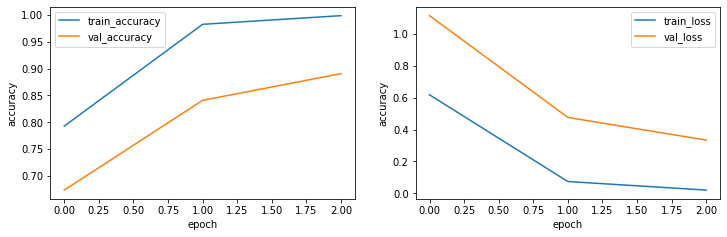

69/69 [==============================] - 73s 1s/step - loss: 0.3341 - accuracy: 0.8905

Train time:  4165.232530593872
Test accuracy: 0.8904545307159424
Test loss: 0.3340523838996887
Test time:  73.41759014129639


In [20]:
model = Sequential()
model.add(MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Flatten())
model.add(Dense(7))
model.add(Softmax())

results(model)

model.save('/content/drive/MyDrive/CS231_Hoang_Nam_Vy/MobileNet.h5')

In [ ]:
results(model)
model.save('/content/drive/MyDrive/CS231_Hoang_Nam_Vy/MobileNet.h5')


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
